#### Compare imputation strategies by defining different pipelines and grid searches and find best pipeline and best estimator for variable y=G21, on dataset with reduced variables. Create additional architecture with Batch Normaliation layer to compare performance.

matplotlib, seaborn

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style('darkgrid')
plt.rcParams['figure.dpi']=150 #resolution in dots per inch

numpy, pandas

In [2]:
import numpy as np
import pandas as pd

from numpy import asarray
from numpy import save
from numpy import load
from numpy import isnan

In [3]:
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
# MinMaxScaler() normalizes, range on the training set, default=(0, 1)

imputers

In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.impute import KNNImputer

import miceforest as mf #multiple imputer

validation methods`

In [5]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

tensorflow

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization

pipeline

In [7]:
from sklearn.pipeline import make_pipeline, Pipeline
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [9]:
#script, function for confusion matrix
%run -i show_confusion_matrix.py

In [10]:
#load data
data = pd.read_csv('data2_droplists.csv')
#make sure dataset has only numbers
data = data.apply(pd.to_numeric)
data.shape

(1838, 668)

In [11]:
#split to dependent and independent variables
X = data.loc[:, data.columns != 'G21'].values #select all but the desired G21 for y { 0 :'Normal', 1 :'MCI', 2 :'Dementia'}
y = data['G21'].values

print(X.shape,y.shape)

(1838, 667) (1838,)


In [12]:
#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10, shuffle=True, stratify=y)


In [13]:
# determine the number of input features for NN input layer
n_features = X.shape[1]

In [14]:
#model definition of NN with possible parameters as arguments

def create_nn(activation = 'relu', 
              optimizer='adam', 
              init='he_normal', 
              layer1_units=64,
              layer2_units=32,
              hidden_layers=1, 
              dropout_rate=0.5):
    # create model
    model = Sequential()
    
    if activation=='relu':
        # Add an input layer
        model.add(Dense(units=layer1_units, 
                        kernel_initializer=init, 
                        activation='relu', 
                        input_shape=(n_features,)))
        for i in range(hidden_layers): # Add hidden layer
            model.add(Dense(layer2_units, 
                        kernel_initializer=init, 
                        activation='relu'))
        
        model.add(Dropout(rate=dropout_rate))
        # Add an output layer
        model.add(Dense(3, activation='softmax'))
        
    if activation=='tanh':
        # Add input layer, giving number of features
        model.add(Dense(layer1_units, 
                        kernel_initializer=init, 
                        activation='tanh', 
                        input_shape=(n_features,)))
        for i in range(hidden_layers): # Add hidden layer based on possible numbers in the grid
            model.add(Dense(layer2_units, 
                        kernel_initializer=init, 
                        activation='tanh'))
        
        model.add(Dropout(rate=dropout_rate))
        # Add output layer for 3 classes od G21, activation has to be softmax for multiclass
        model.add(Dense(3, activation='softmax'))
    
    # Compile model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['sparse_categorical_accuracy']) # 'sparse_categorical_accuracy' because of chosen loss metric
    
    return model
      


In [15]:
#wrap the model create function in KerasClassifier class so as to be able to use with grid search
model_wrap = KerasClassifier(build_fn=create_nn, 
                             activation = 'relu', 
                             optimizer='adam', 
                             init='he_normal', 
                             layer1_units=64,
                             layer2_units=32,
                             hidden_layers=1, 
                             dropout_rate=0.5, 
                             batch_size=32, 
                             epochs=10, 
                             verbose=0)

In [16]:
#pipeline for iterative imputation
pipeline_iter = Pipeline([
    ('scaler', MinMaxScaler()),
    ('imputer', IterativeImputer(max_iter=10,n_nearest_features=200,initial_strategy='most_frequent',imputation_order='ascending')),
    ('model', model_wrap)])
#pipeline for knn imputation
pipeline_knn = Pipeline([
    ('scaler', MinMaxScaler()),
    ('imputer', KNNImputer()),
    ('model', model_wrap)])

In [17]:
#define all grid parameters to search over
param_grid_iter ={
    'scaler': [MinMaxScaler()],
    'model__activation' : ['tanh','relu'],
    'model__optimizer' : ['adam','sgd'],
    'model__init' : ['he_normal'], 
    'model__epochs' : [40],
    'model__batch_size' : [16],
    'model__hidden_layers' : [3],
    'model__dropout_rate' : [0.5,0.7],
    'model__layer1_units' : [32],
    'model__layer2_units' : [32]
    
}

param_grid_knn ={
    'scaler': [MinMaxScaler()], 
    'imputer__n_neighbors' : [3,5,9],
    'model__activation' : ['tanh','relu'],
    'model__optimizer' : ['adam','sgd'],
    'model__init' : ['he_normal'], 
    'model__epochs' : [40],
    'model__batch_size' : [16],
    'model__hidden_layers' : [3],
    'model__dropout_rate' : [0.5,0.7],
    'model__layer1_units' : [32],
    'model__layer2_units' : [32]
    
}

In [18]:
#define the grid and insert pipeline in place of the estimator 
grid_iter = GridSearchCV(estimator=pipeline_iter, 
                    param_grid=param_grid_iter, 
                    scoring='accuracy', 
                    cv = 10,
                    verbose=1,)

grid_knn = GridSearchCV(estimator=pipeline_knn, 
                    param_grid=param_grid_knn, 
                    scoring='accuracy', 
                    cv = 10,
                    verbose=1,)

###### run grid iter

In [19]:
import time
start_time = time.time()

grid_iter.fit(X_train, y_train)
    
#calculate time for fit function
elapsed_time = time.time() - start_time
print(elapsed_time, "seconds for fitting iter gridsearch")

Fitting 10 folds for each of 8 candidates, totalling 80 fits


C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: C

C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: C

C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: C

25277.435774564743 seconds for fitting iter gridsearch


###### run grid knn

In [20]:
start_time = time.time()

grid_knn.fit(X_train, y_train)
    
#calculate time for fit function
elapsed_time = time.time() - start_time
print(elapsed_time, "seconds for fitting iter gridsearch")

Fitting 10 folds for each of 24 candidates, totalling 240 fits
2877.667053461075 seconds for fitting iter gridsearch


##### iterative results

In [21]:
print('Best Iterative imputer params are :\n %s' % grid_iter.best_params_)
# Best training data accuracy
print('\nBest training accuracy: %.3f' % grid_iter.best_score_)
# Predict on test data with best params
y_pred_iter = grid_iter.predict(X_test)
# Test data accuracy of model with best params
print('\nTest set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred_iter))

Best Iterative imputer params are :
 {'model__activation': 'relu', 'model__batch_size': 16, 'model__dropout_rate': 0.7, 'model__epochs': 40, 'model__hidden_layers': 3, 'model__init': 'he_normal', 'model__layer1_units': 32, 'model__layer2_units': 32, 'model__optimizer': 'adam', 'scaler': MinMaxScaler()}

Best training accuracy: 0.929

Test set accuracy score for best params: 0.916 


In [22]:
#evaluation metrics on test set predictions
print("ITERATIVE IMPUTATION RESULTS")
print('\n',confusion_matrix(y_test, y_pred_iter))
print('\n',classification_report(y_test, y_pred_iter))

ITERATIVE IMPUTATION RESULTS

 [[297  11   1]
 [ 13  28   2]
 [  0   4  12]]

               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       309
         1.0       0.65      0.65      0.65        43
         2.0       0.80      0.75      0.77        16

    accuracy                           0.92       368
   macro avg       0.80      0.79      0.79       368
weighted avg       0.92      0.92      0.92       368



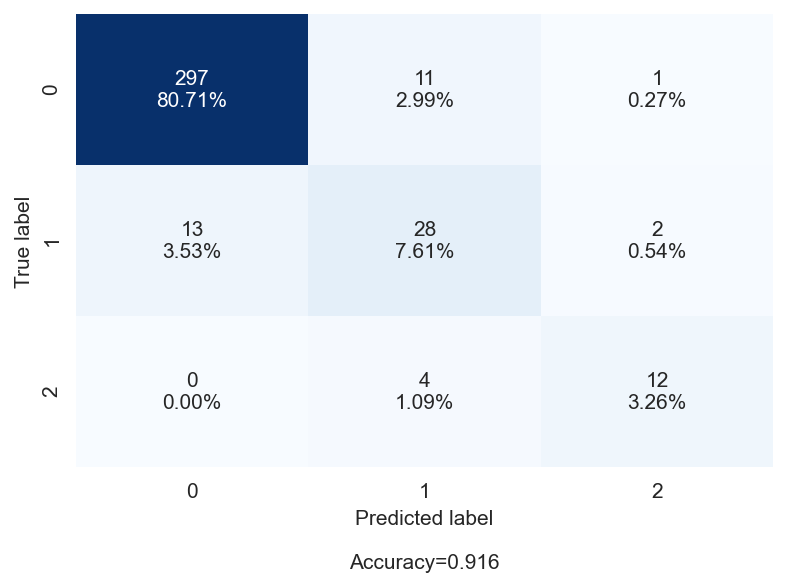

In [23]:
cf_matrix_iter = confusion_matrix(y_test, y_pred_iter)
make_confusion_matrix(cf_matrix_iter, figsize=(6,4), cbar=False)

In [24]:
#extract results to put on a dataframe
means_iter = grid_iter.cv_results_['mean_test_score']
stds_iter = grid_iter.cv_results_['std_test_score']
params_iter = grid_iter.cv_results_['params']

In [25]:
#make df
df_iter=pd.DataFrame(params_iter)
df_iter['Mean']=means_iter
df_iter['Std. Dev']=stds_iter

In [26]:
#save df to file
df_iter.to_csv(r'C:\Users\redi\Desktop\Βαρλαμης\data\grid_G21_df_iter.csv',index=False, float_format='%.4f')
df_iter

,model__activation,model__batch_size,model__dropout_rate,model__epochs,model__hidden_layers,model__init,model__layer1_units,model__layer2_units,model__optimizer,scaler,Mean,Std. Dev
0,tanh,16,0.5,40,3,he_normal,32,32,adam,MinMaxScaler(),0.927211,0.015823
1,tanh,16,0.5,40,3,he_normal,32,32,sgd,MinMaxScaler(),0.925170,0.015211
2,tanh,16,0.7,40,3,he_normal,32,32,adam,MinMaxScaler(),0.922449,0.023408
3,tanh,16,0.7,40,3,he_normal,32,32,sgd,MinMaxScaler(),0.923810,0.019193
4,relu,16,0.5,40,3,he_normal,32,32,adam,MinMaxScaler(),0.921769,0.018815
5,relu,16,0.5,40,3,he_normal,32,32,sgd,MinMaxScaler(),0.925170,0.016939
6,relu,16,0.7,40,3,he_normal,32,32,adam,MinMaxScaler(),0.929252,0.017263
7,relu,16,0.7,40,3,he_normal,32,32,sgd,MinMaxScaler(),0.923129,0.015227


##### knn results

In [27]:
print('Best Knn imputer params are :\n %s' % grid_knn.best_params_)
# Best training data accuracy
print('\nBest training accuracy: %.3f' % grid_knn.best_score_)
# Predict on test data with best params
y_pred_knn = grid_knn.predict(X_test)
# Test data accuracy of model with best params
print('\nTest set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred_knn))

Best Knn imputer params are :
 {'imputer__n_neighbors': 3, 'model__activation': 'tanh', 'model__batch_size': 16, 'model__dropout_rate': 0.5, 'model__epochs': 40, 'model__hidden_layers': 3, 'model__init': 'he_normal', 'model__layer1_units': 32, 'model__layer2_units': 32, 'model__optimizer': 'sgd', 'scaler': MinMaxScaler()}

Best training accuracy: 0.933

Test set accuracy score for best params: 0.905 


In [28]:
#evaluation metrics on test set predictions
print("KNN IMPUTATION RESULTS")
print('\n',confusion_matrix(y_test, y_pred_knn))
print('\n',classification_report(y_test, y_pred_knn))

KNN IMPUTATION RESULTS

 [[299  10   0]
 [ 16  24   3]
 [  0   6  10]]

               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       309
         1.0       0.60      0.56      0.58        43
         2.0       0.77      0.62      0.69        16

    accuracy                           0.90       368
   macro avg       0.77      0.72      0.74       368
weighted avg       0.90      0.90      0.90       368



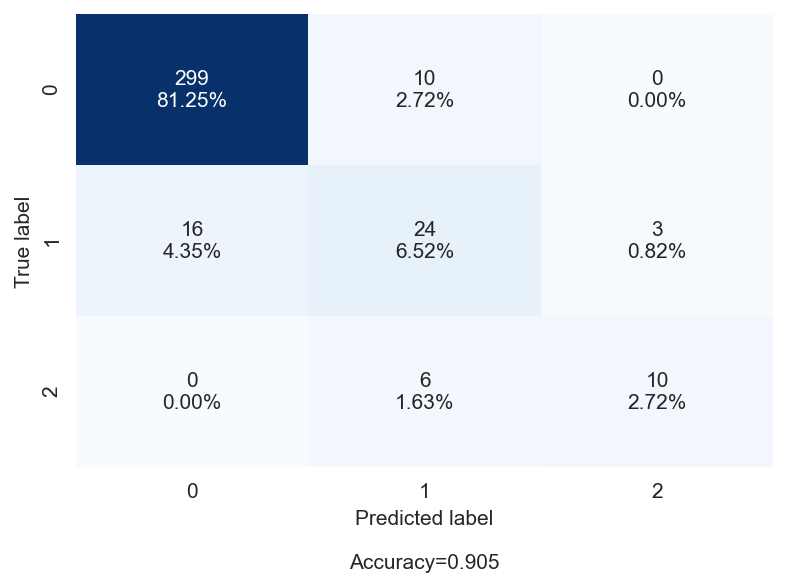

In [29]:
cf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
make_confusion_matrix(cf_matrix_knn, figsize=(6,4), cbar=False)

In [30]:
#extract results to put on a dataframe
means_knn = grid_knn.cv_results_['mean_test_score']
stds_knn = grid_knn.cv_results_['std_test_score']
params_knn = grid_knn.cv_results_['params']


In [31]:
df_knn=pd.DataFrame(params_knn)
df_knn['Mean']=means_knn
df_knn['Std. Dev']=stds_knn

In [32]:
#save df to file
df_knn.to_csv(r'C:\Users\redi\Desktop\Βαρλαμης\data\grid_G21_df_knn.csv',index=False, float_format='%.4f')
df_iter

,model__activation,model__batch_size,model__dropout_rate,model__epochs,model__hidden_layers,model__init,model__layer1_units,model__layer2_units,model__optimizer,scaler,Mean,Std. Dev
0,tanh,16,0.5,40,3,he_normal,32,32,adam,MinMaxScaler(),0.927211,0.015823
1,tanh,16,0.5,40,3,he_normal,32,32,sgd,MinMaxScaler(),0.925170,0.015211
2,tanh,16,0.7,40,3,he_normal,32,32,adam,MinMaxScaler(),0.922449,0.023408
3,tanh,16,0.7,40,3,he_normal,32,32,sgd,MinMaxScaler(),0.923810,0.019193
4,relu,16,0.5,40,3,he_normal,32,32,adam,MinMaxScaler(),0.921769,0.018815
5,relu,16,0.5,40,3,he_normal,32,32,sgd,MinMaxScaler(),0.925170,0.016939
6,relu,16,0.7,40,3,he_normal,32,32,adam,MinMaxScaler(),0.929252,0.017263
7,relu,16,0.7,40,3,he_normal,32,32,sgd,MinMaxScaler(),0.923129,0.015227


### Try Batch Norm layer

In [38]:
#model definition of NN with Batch notmaliation Layer

def create_nn_batch_norm(activation = 'relu', 
              optimizer='adam', 
              init='he_normal', 
              layer1_units=64, 
              layer2_units=32, 
              hidden_layers=1, 
              dropout_rate=0):
    # create model
    model = Sequential()
    
    if activation=='relu':
        # Add an input layer
        model.add(Dense(units=layer1_units, 
                        kernel_initializer=init, 
                        activation='relu', 
                        input_shape=(n_features,)))
        model.add(BatchNormalization())
        for i in range(hidden_layers): # Add hidden layer
            model.add(Dense(layer2_units, 
                        kernel_initializer=init, 
                        activation='relu'))
        
        model.add(BatchNormalization())
        # Add an output layer
        model.add(Dense(3, activation='softmax'))
        
    if activation=='tanh':
        # Add input layer, giving number of features
        model.add(Dense(units=layer1_units, 
                        kernel_initializer=init, 
                        activation='tanh', 
                        input_shape=(n_features,)))
        model.add(BatchNormalization())        
        for i in range(hidden_layers): # Add hidden layer based on possible numbers in the grid
            model.add(Dense(layer2_units, 
                        kernel_initializer=init, 
                        activation='tanh'))
        
        # Add output layer for 3 classes od G21, activation has to be softmax for multiclass
        model.add(Dense(3, activation='softmax'))
    
    # Compile model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['sparse_categorical_accuracy']) # 'sparse_categorical_accuracy' because of chosen loss metric
    
    return model
      


In [39]:
#wrap the model create function in KerasClassifier class so as to be able to use with grid search
model_batch_wrap = KerasClassifier(build_fn=create_nn_batch_norm, 
                             activation = 'relu', 
                             optimizer='adam', 
                             init='he_normal', 
                             layer1_units=32,
                             layer2_units=32,
                             hidden_layers=1,                             
                             batch_size=32, 
                             epochs=10, 
                             verbose=0)

In [40]:
#create a basic pipeline for scaling and imputation
pipeline_batch = Pipeline([
    ('scaler', MinMaxScaler()),
    ('imputer', IterativeImputer(max_iter=10,n_nearest_features=200,initial_strategy='most_frequent',imputation_order='ascending')),
    ('model', model_batch_wrap)])

In [41]:
#define all grid parameters to search over
param_grid_batch ={
    'scaler': [MinMaxScaler()],
    'model__activation' : ['relu'],
    'model__optimizer' : ['adam'],
    'model__init' : ['he_normal'], 
    'model__epochs' : [40],
    'model__batch_size' : [16],
    'model__hidden_layers' : [3],
    'model__layer1_units' : [32], 
    'model__layer1_units' : [32]
    
}
grid_batch = GridSearchCV(estimator=pipeline_batch, 
                    param_grid=param_grid_batch, 
                    scoring='accuracy', 
                    cv = 10,
                    verbose=1,)

In [42]:
import time
start_time = time.time()

#fit grid search on training data
grid_batch.fit(X_train, y_train)

#calculate time for fit function
elapsed_time = time.time() - start_time
print(elapsed_time, "seconds for fitting batch norm gridsearch")

Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: C

3799.584284543991 seconds for fitting batch norm gridsearch


In [43]:
print('Best batch norm params are :\n %s' % grid_batch.best_params_)
# Best training data accuracy
print('\nBest training accuracy: %.3f' % grid_batch.best_score_)
# Predict on test data with best params
y_pred_batch = grid_batch.predict(X_test)
# Test data accuracy of model with best params
print('\nTest set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred_knn))

Best batch norm params are :
 {'model__activation': 'relu', 'model__batch_size': 16, 'model__epochs': 40, 'model__hidden_layers': 3, 'model__init': 'he_normal', 'model__layer1_units': 32, 'model__optimizer': 'adam', 'scaler': MinMaxScaler()}

Best training accuracy: 0.909

Test set accuracy score for best params: 0.905 


In [44]:
#evaluation metrics on test set predictions
print("BATCH NORM RESULTS")
print('\n',confusion_matrix(y_test, y_pred_batch))
print('\n',classification_report(y_test, y_pred_batch))

BATCH NORM RESULTS

 [[299   9   1]
 [ 22  20   1]
 [  0   5  11]]

               precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       309
         1.0       0.59      0.47      0.52        43
         2.0       0.85      0.69      0.76        16

    accuracy                           0.90       368
   macro avg       0.79      0.71      0.74       368
weighted avg       0.89      0.90      0.89       368



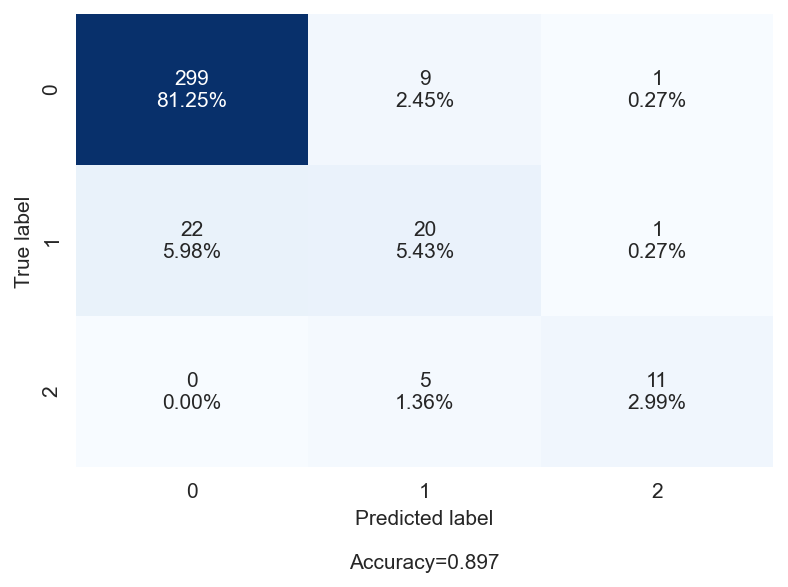

In [45]:
cf_matrix_batch = confusion_matrix(y_test, y_pred_batch)
make_confusion_matrix(cf_matrix_batch, figsize=(6,4), cbar=False)

In [46]:
#extract results to put on a dataframe
means_batch = grid_batch.cv_results_['mean_test_score']
stds_batch = grid_batch.cv_results_['std_test_score']
params_batch = grid_batch.cv_results_['params']

In [47]:
df_batch=pd.DataFrame(params_batch)
df_batch['Mean']=means_batch
df_batch['Std. Dev']=stds_batch

In [48]:
#save df to file
df_batch.to_csv(r'C:\Users\redi\Desktop\Βαρλαμης\data\grid_G21_df_batch.csv',index=False, float_format='%.4f')
df_batch

,model__activation,model__batch_size,model__epochs,model__hidden_layers,model__init,model__layer1_units,model__optimizer,scaler,Mean,Std. Dev
0,relu,16,40,3,he_normal,32,adam,MinMaxScaler(),0.908844,0.019527


#### violin plots of different parameters in gridsearch with accuracy

In [13]:
d = pd.read_csv('grid_G21_df_iter.csv')

Plots from iterative imputer grid


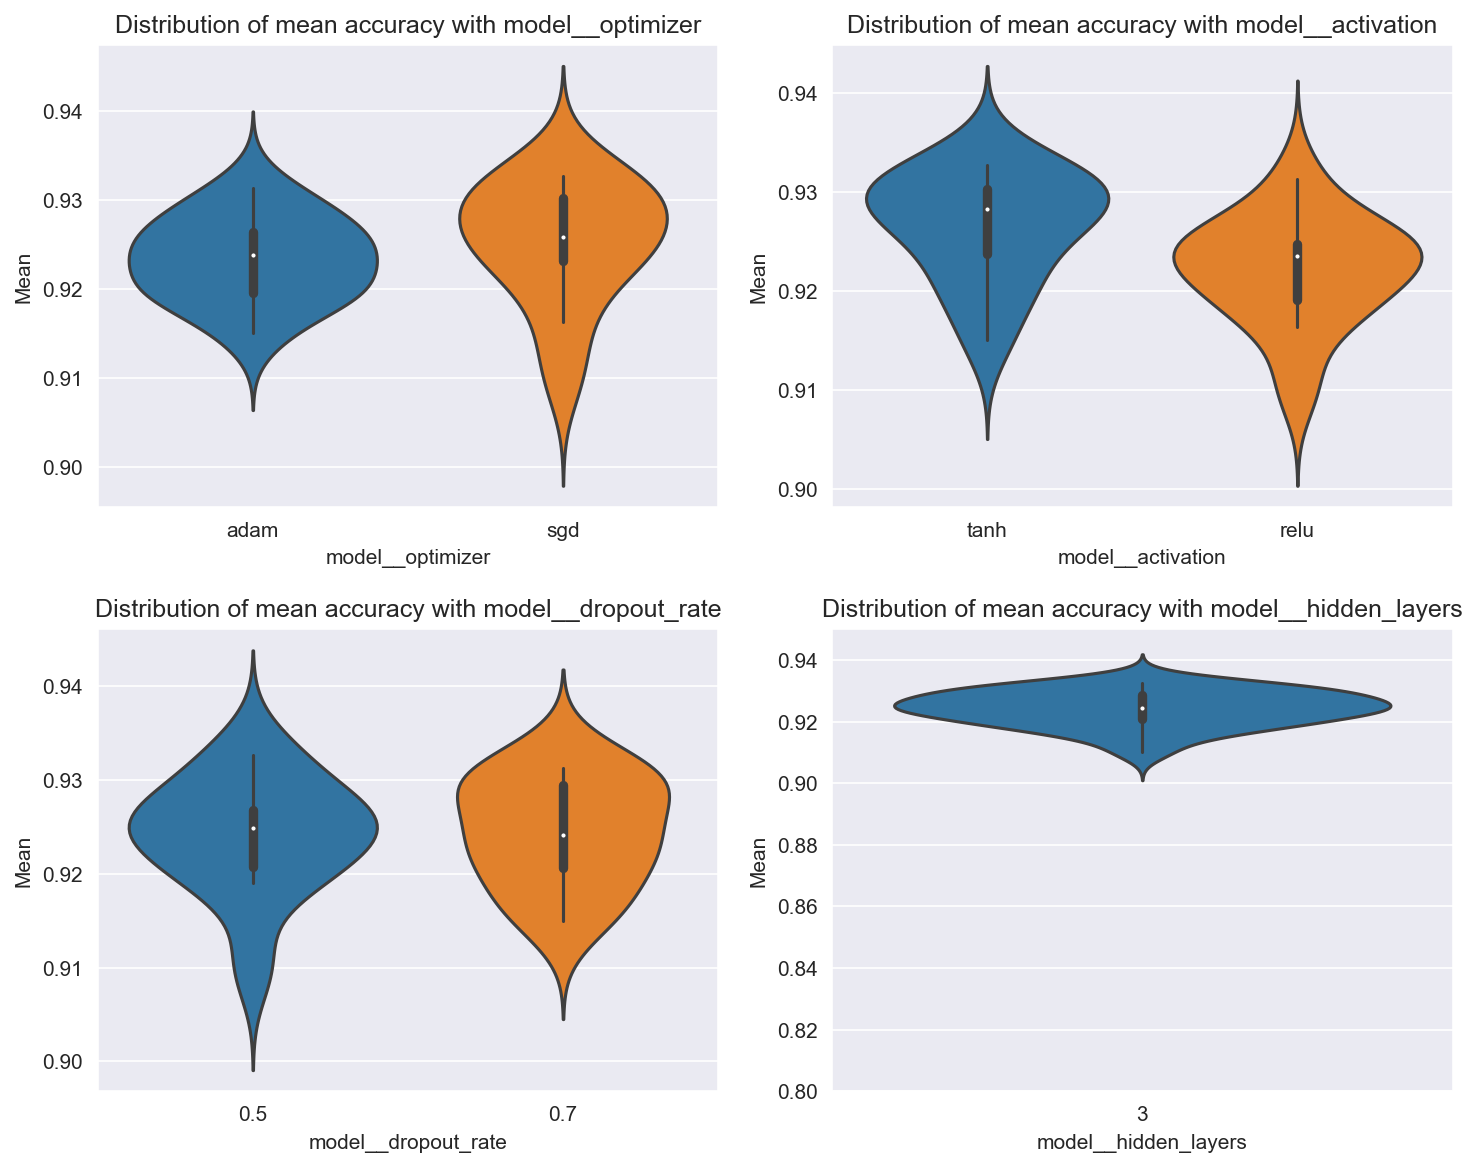

In [32]:
#get specific parameters to plot
params_ = ['model__optimizer','model__activation','model__dropout_rate', 'model__hidden_layers']

#violin plots 
fig, ax = plt.subplots(2,2,figsize=(10,8), squeeze=True)
ax = ax.ravel()
plt.ylim(0.8, 0.95)
for i in range(4):
    ax[i].set_title('Distribution of mean accuracy with {}'.format(params_[i]))
    sns.violinplot(x=params_[i],y='Mean',data=d,cut=3,ax=ax[i])   
fig.tight_layout(pad=1.5)

print("Plots from iterative imputer grid")

In [22]:
d = pd.read_csv('grid_G21_df_knn.csv')

Plots from knn imputer grid


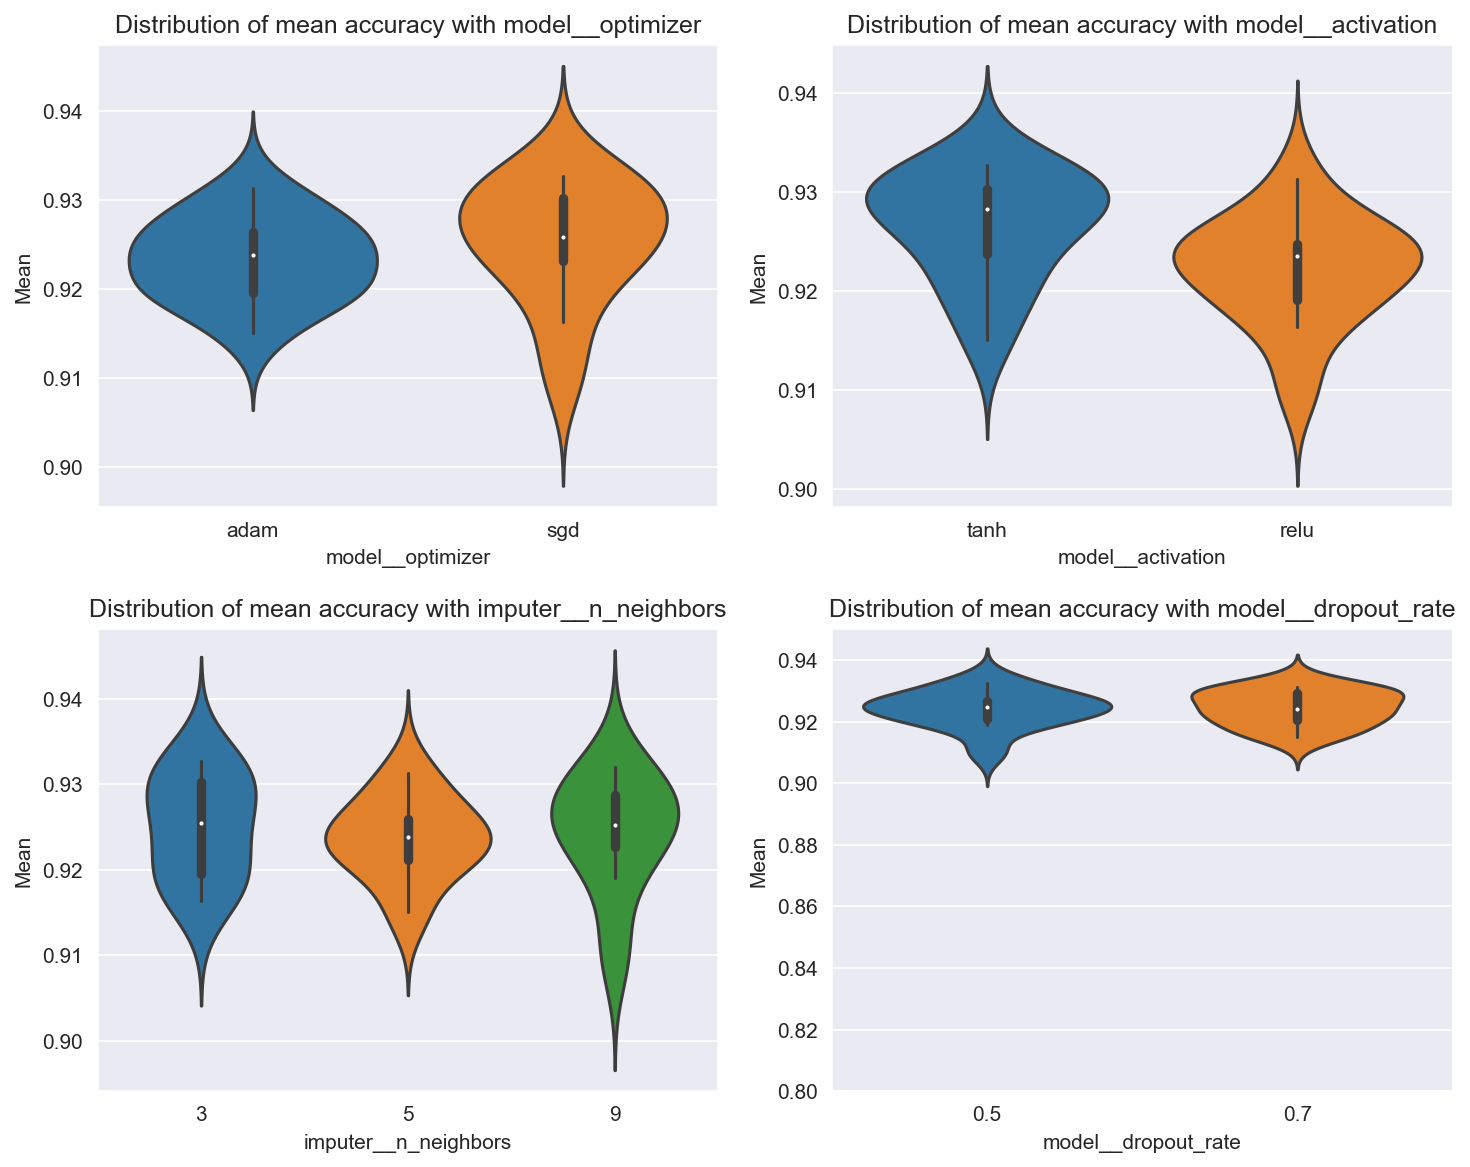

In [30]:
#get specific parameters to plot
params_ = ['model__optimizer','model__activation','imputer__n_neighbors','model__dropout_rate']

#violin plots
fig, ax = plt.subplots(2,2,figsize=(10,8), squeeze=True)
ax = ax.ravel()
plt.ylim(0.8, 0.95)
for i in range(4):
    ax[i].set_title('Distribution of mean accuracy with {}'.format(params_[i]))
    sns.violinplot(x=params_[i],y='Mean',data=d,cut=3,ax=ax[i])   
fig.tight_layout(pad=1.5)

print("Plots from knn imputer grid")